In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from tqdm import tqdm
from collections import Counter

In [2]:
#데이터 생성

random.seed(100)
blue_means = np.random.multivariate_normal([1,0],[[1,0],[0,1]],10)
orange_means = np.random.multivariate_normal([0,1],[[1,0],[0,1]],10)

num_samples = 5100
blue_samples = []
orange_samples = []

for i in range(num_samples):
    blue_mk = random.sample(list(blue_means),k=1)[0]
    blue_sample = np.random.multivariate_normal(blue_mk,[[1/5,0],[0,1/5]],1)
    blue_samples.append(np.squeeze(blue_sample))
    
    orange_mk = random.sample(list(orange_means),k=1)[0]
    orange_sample = np.random.multivariate_normal(orange_mk,[[1/5,0],[0,1/5]],1)
    orange_samples.append(np.squeeze(orange_sample))
    
num_train_samples = 100
train_samples = (blue_samples[:num_train_samples], orange_samples[:num_train_samples])
test_samples = (blue_samples[num_train_samples:], orange_samples[num_train_samples:])

X=[]
y=[]

for j in range(len(train_samples)):
    for data in train_samples[j]:
        y.append(j)
        temp = []
        temp += [data[0],data[1]]
        
        X.append(temp)
        
y = np.array(y)
X = np.array(X)

df = pd.DataFrame(X, columns=['x1','x2'])
df['y'] = y

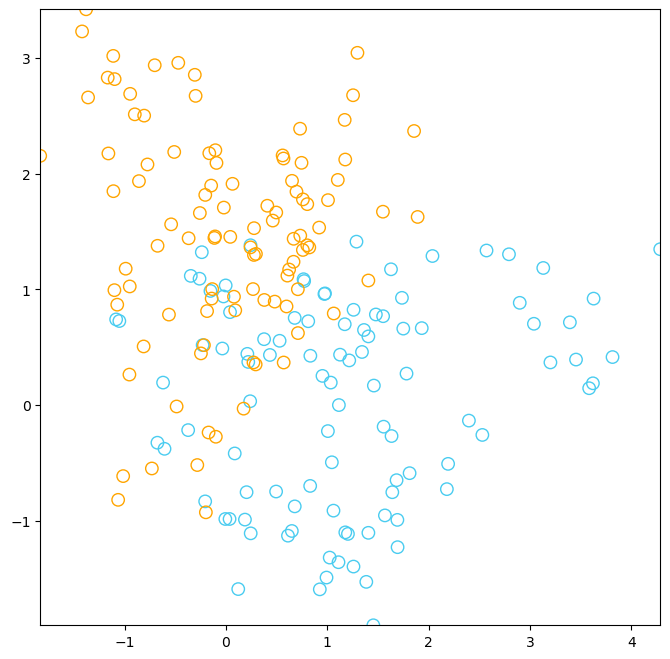

In [3]:
#데이터 분포

fig = plt.figure(figsize=(8,8))
colors = ['#4accf0','orange']

for j in range(len(train_samples)):
    x1_s = []
    x2_s = []
    
    for data in train_samples[j]:
        x1_s.append(data[0])
        x2_s.append(data[1])
        
    plt.scatter(x1_s,x2_s, s=80,facecolor='none', edgecolors=colors[j])
        
num_grid = 100
grid_x1 = np.linspace(min(df['x1']), max(df['x1']), num_grid+1)
grid_x2 = np.linspace(min(df['x2']), max(df['x2']), num_grid+1)
plt.xlim(min(df['x1']),max(df['x1']))
plt.ylim(min(df['x2']),max(df['x2']))

plt.show()

In [4]:
#모델 구현

def knn_predict(data,X,y,k=1):
    distances = []
    for val in X:
        distance = np.linalg.norm(data-val)
        distances.append(distance)
        
    distances = np.array(distances)
    if k < len(distances):
        idx = np.argpartition(distances, k)
        prediction = Counter(y[idx[:k]]).most_common()[0][0]
    else:
        prediction = Counter(y).most_common()[0][0]
    return prediction

In [5]:
k = 1
predict = []
for j in range(len(df['x1'])):
    data = [df['x1'][j],df['x2'][j]]
    data = np.array(data)
    predict.append(knn_predict(data,X,y,k))

predict = np.array(predict)
ktre = 1- (y==predict).mean()
print(ktre)

0.0


In [6]:
df['x1'][0]

1.8009293429710063

In [7]:
k = 15
predict = []
for j in range(len(df['x1'])):
    data = [df['x1'][j],df['x2'][j]]
    data = np.array(data)
    predict.append(knn_predict(data,X,y,k))

predict = np.array(predict)
ktre = 1- (y==predict).mean()
print(ktre)

0.16000000000000003


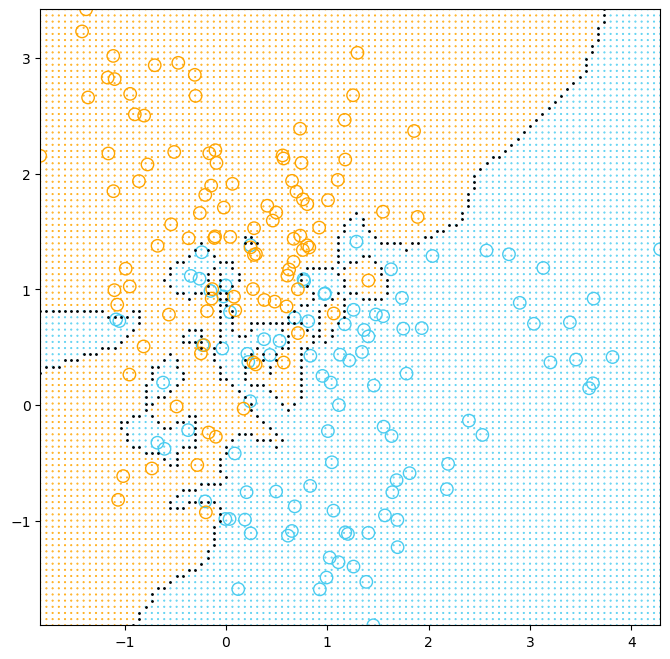

In [8]:
def get_boundary(data, mod, target):
    temp = []
    for i in range(len(data)):
        center = data[i]
        if (i+1)%mod >1:
            direction = [i-1,i+1,i+mod,i-mod]
        elif (i+1)%mod ==1:
            direction = [i+1,i+mod,i-mod]
        else:
            direction = [i-1,i+mod,i-mod]
            
        valid_idx = [x for x in direction if (x>=0 and x<= len(data)-1)]
        
        for v in valid_idx:
            if center != data[v]:
                temp.append(i)
                continue
                
    res = []
    for r in list(set(temp)):
        if data[r] == target:
            res.append(r)
            
    return list(set(res))

num_grid = 100
grid_x1 = np.linspace(min(df['x1']),max(df['x1']), num_grid+1)
grid_x2 = np.linspace(min(df['x2']),max(df['x2']), num_grid+1)

temp_x1, temp_x2 = np.meshgrid(grid_x1,grid_x2)
positions = np.vstack([temp_x2.ravel(), temp_x1.ravel()])

k = 1
grid_colors = []
for i in range(positions.shape[1]):
    data = np.array([positions[1][i],positions[0][i]])
    grid_colors.append(colors[knn_predict(data,X,y,k)])
    
boundary_idx = get_boundary(grid_colors,101,'#4accf0')
bx1 = positions[::-1][0][boundary_idx]
bx2 = positions[::-1][1][boundary_idx]

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')

plt.xlim(min(df['x1']),max(df['x1']))
plt.ylim(min(df['x2']),max(df['x2']))

for j in range(len(train_samples)):
    x1_s = []
    x2_s = []
    
    for data in train_samples[j]:
        x1_s.append(data[0])
        x2_s.append(data[1])
        
    plt.scatter(x1_s,x2_s, s=80,facecolor='none', edgecolors=colors[j])
    
plt.scatter(*positions[::-1],color=grid_colors,s=0.25,zorder=-10)
plt.scatter(bx1,bx2,s=1,color='k')
plt.show()

In [9]:
#최적의 k

test_y = []
test_x1 =[]
test_x2 = []

for j in range(len(test_samples)):
    for data in test_samples[j]:
        test_y.append(j)
        temp = []
        test_x1.append(data[0])
        test_x2.append(data[1])
        
test_x1 = np.array(test_x1)
test_x2 = np.array(test_x2)

knn_train_error = []
knn_test_error = []
ks = range(1,200)

for k in tqdm(ks):
    predict = []
    
    for j in range(len(df['x1'])):
        data = [df['x1'][j], df['x2'][j]]
        data = np.array(data)
        predict.append(knn_predict(data,X,y,k))
        
    predict = np.array(predict)
    ktre  = 1- (y==predict).mean()
    knn_train_error.append(ktre)
    
    t_predict = []
    
    for j in range(len(test_x1)):
        data = [test_x1[j], test_x2[j]]
        data = np.array(data)
        t_predict.append(knn_predict(data,X,y,k))
        
    t_predict = np.array(t_predict)
    kte = 1 - (test_y == t_predict).mean()
    knn_test_error.append(kte)

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [24:21<00:00,  7.34s/it]


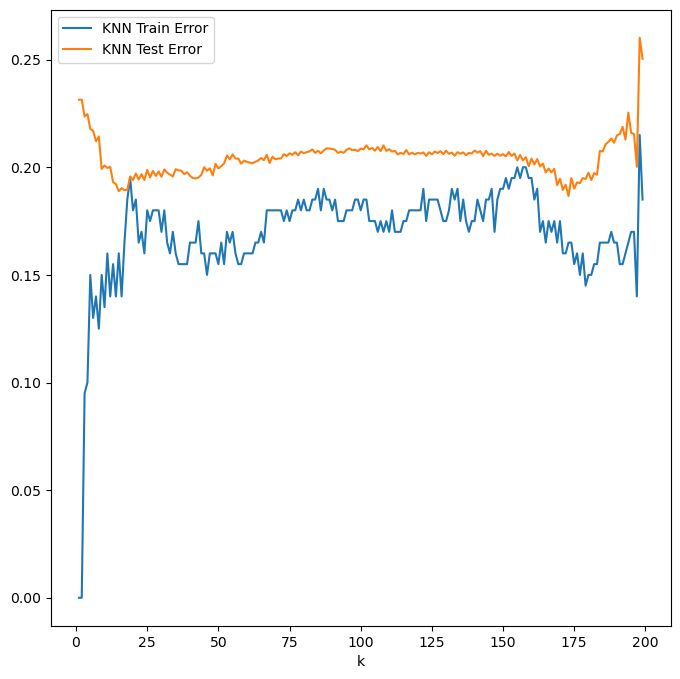

In [10]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
plt.plot(ks, knn_train_error, label='KNN Train Error')
plt.plot(ks, knn_test_error, label='KNN Test Error')
plt.legend()
plt.xlabel('k')
plt.show()

In [11]:
min_idx = knn_test_error.index(min(knn_test_error))
ks[min_idx]

173

In [12]:
#실제 데이터

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [13]:
iris = load_iris()
df = pd.DataFrame(np.c_[iris['data'],iris['target']], columns=iris['feature_names']+['label'])

In [14]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [15]:
x = df[iris['feature_names']]
y = df['label']
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.2, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x,train_y,test_size=0.33, random_state=42)

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 76.40it/s]


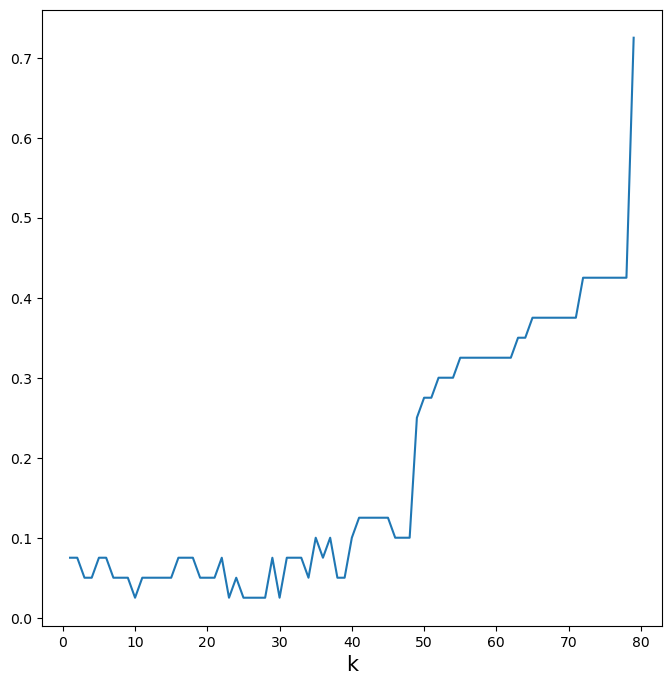

In [16]:
knn_val_error = []
ks = range(1, len(train_x))
for k in tqdm(ks):
    predict = []
    for j in range(len(val_x)):
        data=val_x.values[j]
        data=np.array(data)
        predict.append(knn_predict(data,train_x.values, train_y.values,k))
        
    predict = np.array(predict)
    ktre = 1- (val_y == predict).mean()
    knn_val_error.append(ktre)
    
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')

plt.plot(ks, knn_val_error)
plt.xlabel('k', fontsize=15)
plt.show()

In [17]:
min_val_error = min(knn_val_error)
opt_k = knn_val_error.index(min_val_error)+1
opt_k

10

In [18]:
k = opt_k
knn_test_error=[]

predict=[]
for j in range(len(test_x)):
    data = test_x.values[j]
    data= np.array(data)
    predict.append(knn_predict(data, train_x.values, train_y.values,k))
    
predict = np.array(predict)
kte = 1-(test_y==predict).mean()
kte

0.0

In [19]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=opt_k)
neigh.fit(train_x.values, train_y.values)

knn_test_error = []

predict = []

for j in range(len(test_x)):
    data = test_x.values[j]
    data = np.array(data)
    data=np.expand_dims(data,axis=0)
    predict.append(neigh.predict(data))
    
predict = np.squeeze(predict)
kte = 1 - (test_y == predict).mean()

In [20]:
kte

0.0